In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd


model_checkpoint = 'cointegrated/rubert-base-cased-nli-twoway'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

def predict_pair(text1, text2):
    with torch.inference_mode():
        out = model(**tokenizer(text1, text2, return_tensors='pt').to(model.device))
        proba = torch.softmax(out.logits, -1).cpu().numpy()[0]
        return {v: proba[k] for k, v in model.config.id2label.items()}['entailment']

In [ ]:
import json

ppp = json.loads(open('ParaPhraserPlus.json').read())

In [ ]:
len(ppp)

In [ ]:
ppp['0']

In [ ]:
import tqdm
from itertools import permutations

with open('ppp_entailment_pairs.jsonl', 'w', encoding='utf8') as f:
    for i, row in tqdm.tqdm(ppp.items()):
        cluster_id = i
        for pair in permutations(set(row['headlines']), 2):
            try:
                proba = predict_pair(*pair)
            except RuntimeError as e:
                print(e)
                continue
            f.write(json.dumps({
                "cluster_id": cluster_id,
                "text1": pair[0],
                "text2": pair[1],
                "proba": float(proba)
            }, ensure_ascii=False)+'\n')
#             data.append((cluster_id, *pair, proba))

In [ ]:
import json
import tqdm


data = []
for line in tqdm.tqdm(open('data/ppp_entailment.jsonl'), total=31060464):
    data.append(tuple(json.loads(line).values()))

In [ ]:
import pandas as pd

data = pd.DataFrame(data)

In [ ]:
data.columns = ['cluster_id', 'text1', 'text2', 'ent']

In [ ]:
df2 = data.copy()
df2.columns = ['cluster_id', 'text2', 'text1', 'ent']

In [ ]:
data = data.merge(df2, on = ['text1', 'text2'])

In [ ]:
import gc

In [ ]:
del df2
gc.collect()

In [ ]:
data.to_csv('data/ppp_entailment_test.tsv', sep='\t', index=False)

In [ ]:
import numpy as np

dupes = pd.DataFrame(np.sort(data[['text1', 'text2']].values, axis=1),
                     index=data[['text1', 'text2']].index,
                     columns=data[['text1', 'text2']].columns)
data = data[~dupes.duplicated()]

In [ ]:
data = data[['cluster_id_x', 'text1', 'text2', 'ent_x', 'ent_y']]
data.columns = ['cluster_id', 'text1', 'text2', 'ent1', 'ent2']

In [ ]:
del dupes

In [ ]:
gc.collect()

In [ ]:
data.to_csv('data/ppp_entailment_test.tsv', sep='\t', index=False)

In [2]:
import pandas as pd

df = pd.read_csv('data/ppp_entailment_test.tsv', sep='\t')

In [5]:
df = df[(df.ent1 > 0.7) & (df.ent2 > 0.7)]

In [7]:
df

,cluster_id,text1,text2,ent1,ent2
51,16,Пепел камчатского вулкана Шивелуч угрожает ави...,На Камчатке пепел от вулкана Шивелуч угрожает ...,0.955676,0.806798
52,16,Пепел камчатского вулкана Шивелуч угрожает ави...,Пепел вулкана Шивелуч поставил под угрозу авиа...,0.783761,0.719882
54,16,На Камчатке пепел от вулкана Шивелуч угрожает ...,Пепел вулкана Шивелуч поставил под угрозу авиа...,0.910644,0.974905
62,19,При пожаре в общежитии в Нижнем Тагиле погибли...,В Нижнем Тагиле два человека погибли при пожар...,0.958635,0.944878
63,19,При пожаре в общежитии в Нижнем Тагиле погибли...,Два человека погибли в результате пожара в общ...,0.965440,0.974930
...,...,...,...,...,...
13106876,1725369,Рязанцев продлил контракт с Рубином,"Рязанцев продлил соглашение с ""Рубином""",0.935678,0.918486
13106920,1725372,На переговорах между Москвой и Минском не удал...,Переговоры о поставках нефти из России в Белор...,0.876671,0.761887
13106936,1725374,СМИ: уполномоченным по правам ребенка в РФ наз...,Павел Астахов назначен уполномоченным по права...,0.970460,0.800465
13106952,1725377,Космонавты на МКС смогут отпраздновать Новый г...,Космонавты с МКС встретят Новый год 16 раз,0.956374,0.987361


In [23]:
from alphabet_detector import AlphabetDetector
ad = AlphabetDetector()


df = df[~(df.text1.apply(lambda x: ad.is_latin(x)))]
df = df[~(df.text2.apply(lambda x: ad.is_latin(x)))]

In [25]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [26]:
df['leven'] = df.apply(lambda x: similar(x['text1'], x['text2']), axis=1)

<AxesSubplot:>

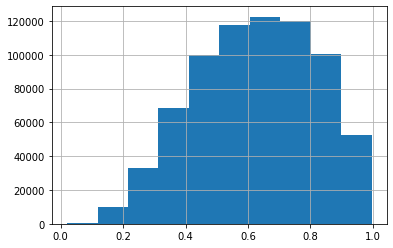

In [27]:
df['leven'].hist()

In [46]:
df = df[df['leven'] < 0.82]

In [56]:
len(df)

592564

In [57]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)
from collections import Counter
from razdel import tokenize

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

def match_ents(s1, s2):
    doc1, doc2 = Doc(s1), Doc(s2)
    
    doc1.segment(segmenter)
    doc2.segment(segmenter)
    
    doc1.tag_ner(ner_tagger)
    doc2.tag_ner(ner_tagger)
    
    if Counter([s.type for s in doc1.spans]) != Counter([s.type for s in doc2.spans]):
        return False
    
    numbers1 = set()
    numbers2 = set()
    
    for tok in doc1.tokens:
        if has_numbers(tok.text):
            numbers1.add(tok.text)
    
    for tok in doc2.tokens:
        if has_numbers(tok.text):
            numbers2.add(tok.text)
    
    if numbers1 != numbers2:
        return False
    
    return True
    

def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

def match_abbr(s1, s2):
    abbrs1 = set()
    abbrs2 = set()
    
    for tok in tokenize(s1):
        if tok.text.isupper() and len(tok.text) > 1:
            abbrs1.add(tok.text)
    for tok in tokenize(s2):
        if tok.text.isupper() and len(tok.text) > 1:
            abbrs2.add(tok.text)
    if abbrs1 == abbrs2:
        return True
    return False

def match_latin(s1, s2):
    lat1 = set()
    lat2 = set()
    
    for tok in tokenize(s1):
        if ad.islatin(tok.text):
            lat1.add(tok.text)
    for tok in tokenize(s2):
        if ad.islatin(tok.text):
            lat2.add(tok.text)

    if lat1 == lat2:
        return True
    return False

In [58]:
df = df[df.apply(lambda x: match_abbr(x['text1'], x['text2']), axis=1)]

In [62]:
import tqdm

ner_data = []
for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    if match_ents(row['text1'], row['text2']):
        ner_data.append(i)

100%|██████████| 503638/503638 [20:08<00:00, 416.81it/s]


In [66]:
df = df[df.index.isin(ner_data)]

In [67]:
len(df)

341411

In [84]:
def same(s1, s2):
    toks1 = set([_.text.lower() for _ in tokenize(s1) if _.text.isalpha()])
    toks2 = set([_.text.lower() for _ in tokenize(s2) if _.text.isalpha()])
#     print(toks1, toks2)
    if toks1 == toks2:
        return True
    return False

In [85]:
df = df[~df.apply(lambda x: same(x['text1'], x['text2']), axis=1)]

In [86]:
len(df)

319709

In [108]:
k = df.sample(1).iloc[0]
print(k['text1'])
print(k['text2'])

Три человека погибли в результате столкновения 20 контейнерных грузовиков в Шанхае
При столкновении 20 фур в Шанхае погибли три человека


In [109]:
df.to_csv('data/clean/ppp_clean.tsv', sep='\t', index=False)